### =========================
### PIPELINE HIDROLÓGICO COMPLETO
### =========================

In [1]:
# Ajuste apenas o caminho do arquivo abaixo se necessário:
arquivo = "61078000_Vazoes.csv"   # <-- coloque caminho completo se o arquivo não estiver na pasta do notebook
ano_fim_previsao = 2030
epsilon_log = 1e-6  # pequeno valor para estabilidade no log1p

### Imports

In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize': (14,6)})



### Verificar a Existência do Arquivo

In [3]:

if not os.path.exists(arquivo):
    raise FileNotFoundError(f"Arquivo não encontrado: {arquivo}")

# -------------------------
# 1) Encontrar linha de cabeçalho da tabela (automático)
# -------------------------
def encontrar_linha_tabela(path):
    with open(path, 'r', encoding='latin1') as f:
        for i, linha in enumerate(f):
            if linha.startswith("EstacaoCodigo"):
                return i
    return None

linha_tabela = encontrar_linha_tabela(arquivo)
if linha_tabela is None:
    linha_tabela = 15  # fallback
print(f"Linha da tabela detectada (0-index): {linha_tabela}")

# -------------------------
# 2) Ler CSV (sep=';') de forma robusta
# -------------------------
df_raw = pd.read_csv(
    arquivo,
    sep=';',
    encoding='latin1',
    engine='python',
    skiprows=linha_tabela,
    decimal=',',
    skip_blank_lines=True
)

# Normalizar nomes de colunas
df_raw.columns = df_raw.columns.str.strip()

# Identificar coluna de Data e colunas Vazao01..Vazao31 (tolerante)
id_col_candidates = [c for c in df_raw.columns if 'data' in c.lower()]
if len(id_col_candidates) == 0:
    raise KeyError("Não foi possível encontrar coluna de Data no CSV. Verifique o cabeçalho.")
id_col = id_col_candidates[0]

vaz_cols = [c for c in df_raw.columns if c.lower().startswith('vazao') and 'status' not in c.lower()]
if len(vaz_cols) == 0:
    raise KeyError("Não encontrou colunas Vazao01..Vazao31 no CSV lido.")

print(f"Coluna Data detectada: {id_col}")
print(f"{len(vaz_cols)} colunas de vazão detectadas (ex.: {vaz_cols[:3]})")



Linha da tabela detectada (0-index): 15
Coluna Data detectada: Data
31 colunas de vazão detectadas (ex.: ['Vazao01', 'Vazao02', 'Vazao03'])


In [4]:
# -------------------------
# 1) Transformar mensal -> diário (formato longo)
# -------------------------

df_long = df_raw.melt(
    id_vars=[id_col],
    value_vars=vaz_cols,
    var_name='DiaCol',
    value_name='Vazao'
)

# Extrair dia numérico da string 'Vazao01' -> 1
df_long['Dia'] = df_long['DiaCol'].str.extract('(\d+)').astype(float).astype('Int64')

# Converter coluna de mês (Data) no formato DD/MM/YYYY — robusto
df_long[id_col] = df_long[id_col].astype(str).str.strip()
df_long['DataMes'] = pd.to_datetime(df_long[id_col], format='%d/%m/%Y', dayfirst=True, errors='coerce')

# Função segura para criar DataCompleta (filtra dias inválidos como 31/02)
def criar_data_segura(row):
    if pd.isna(row['DataMes']) or pd.isna(row['Dia']):
        return pd.NaT
    ano = int(row['DataMes'].year)
    mes = int(row['DataMes'].month)
    dia = int(row['Dia'])
    ultimo_dia = pd.Period(f"{ano}-{mes:02d}", freq="M").days_in_month
    if 1 <= dia <= ultimo_dia:
        return pd.Timestamp(year=ano, month=mes, day=dia)
    else:
        return pd.NaT

df_long['DataCompleta'] = df_long.apply(criar_data_segura, axis=1)
df_long = df_long.dropna(subset=['DataCompleta']).reset_index(drop=True)

# Converter Vazao para float (garantir decimal correto)
df_long['Vazao'] = pd.to_numeric(df_long['Vazao'].astype(str).str.replace(',', '.'), errors='coerce')

# Criar colunas auxiliares
df_long['Ano'] = df_long['DataCompleta'].dt.year
df_long['Mes'] = df_long['DataCompleta'].dt.month

# Ordenar por data
df_long = df_long.sort_values('DataCompleta').reset_index(drop=True)

# -------------------------
# 2) Exportar CSV diário limpo
# -------------------------
df_long.to_csv(
    "Vazao_Diaria_ANA_Limpa.csv",
    index=False,
    encoding='utf-8'
)
print("CSV diário salvo: Vazao_Diaria_ANA_Limpa.csv")

CSV diário salvo: Vazao_Diaria_ANA_Limpa.csv


### -------------------------
### 4) Funções gráficas e análises
### -------------------------

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from prophet import Prophet

# Criar pasta Graficos se não existir
os.makedirs("Graficos", exist_ok=True)

def salvar_e_mostrar(fig, nome_arquivo):
    """
    Salva a figura na pasta Graficos e mostra no notebook/IDE.
    """
    caminho = os.path.join("Graficos", nome_arquivo)
    fig.savefig(caminho, dpi=300, bbox_inches='tight')
    plt.show()

# -----------------------------
# Funções adaptadas
# -----------------------------
def grafico_serie_temporal(df, return_fig=False):
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(df['DataCompleta'], df['Vazao'], label='Vazão Diária', color='skyblue', alpha=0.6)
    x = np.arange(len(df))
    y = df['Vazao'].fillna(method='ffill').fillna(method='bfill').values
    low = lowess(y, x, frac=0.02, return_sorted=False)
    ax.plot(df['DataCompleta'], low, label='Tendência (LOWESS)', color='red', linewidth=2)
    ax.set_title('Série Temporal da Vazão (com Tendência)', fontsize=16)
    ax.set_xlabel('Data')
    ax.set_ylabel('Vazão (m³/s)')
    ax.legend()
    ax.grid(True)
    if return_fig: return fig
    else: plt.show()


def grafico_boxplot_mensal(df, return_fig=False):
    fig, ax = plt.subplots(figsize=(16,6))
    sns.boxplot(x='Mes', y='Vazao', data=df, showfliers=False, palette='coolwarm', ax=ax)
    ax.set_title('Boxplot Mensal da Vazão (sem outliers)', fontsize=16)
    ax.set_xlabel('Mês')
    ax.set_ylabel('Vazão (m³/s)')
    if return_fig: return fig
    else: plt.show()


def heatmap_ano_mes(df, return_fig=False):
    pivot = df.pivot_table(index='Ano', columns='Mes', values='Vazao', aggfunc='mean')
    fig, ax = plt.subplots(figsize=(14,10))
    sns.heatmap(pivot, cmap='YlGnBu', cbar_kws={'label':'Vazão média (m³/s)'}, linewidths=0.4, ax=ax)
    ax.set_title('Heatmap Ano × Mês (Vazão média)', fontsize=14)
    ax.set_xlabel('Mês')
    ax.set_ylabel('Ano')
    if return_fig: return fig
    else: plt.show()


def comparacao_media_historica(df, return_fig=False):
    temp = df.copy()
    temp['DiaAno'] = temp['DataCompleta'].dt.dayofyear
    media_diaria = temp.groupby('DiaAno')['Vazao'].mean()
    media_full = temp['DiaAno'].map(media_diaria)
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(df['DataCompleta'], df['Vazao'], color='skyblue', alpha=0.35, label='Observado')
    ax.plot(df['DataCompleta'], media_full, color='red', linewidth=2, label='Média Histórica')
    ax.set_title('Vazão Observada vs Média Histórica (dia do ano)', fontsize=14)
    ax.set_xlabel('Data')
    ax.set_ylabel('Vazão (m³/s)')
    ax.legend()
    if return_fig: return fig
    else: plt.show()


def grafico_por_decada(df, return_fig=False):
    df2 = df.copy()
    df2['Decada'] = (df2['Ano'] // 10) * 10
    fig, ax = plt.subplots(figsize=(14,6))
    sns.boxplot(x='Decada', y='Vazao', data=df2, showfliers=False, palette='viridis', ax=ax)
    ax.set_title('Distribuição das Vazões por Década', fontsize=14)
    ax.set_xlabel('Década')
    ax.set_ylabel('Vazão (m³/s)')
    if return_fig: return fig
    else: plt.show()


def detectar_secas_cheias(df, indices, return_fig=False):
    dfc = df.copy()
    dfc['Evento'] = 'Normal'
    dfc.loc[dfc['Vazao'] <= indices['Q5'], 'Evento'] = 'Seca'
    dfc.loc[dfc['Vazao'] >= indices['Q95'], 'Evento'] = 'Cheia'

    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(dfc['DataCompleta'], dfc['Vazao'], color='gray', alpha=0.6, label='Vazão')
    if dfc[dfc['Evento']=='Seca'].shape[0] > 0:
        ax.scatter(dfc[dfc['Evento']=='Seca']['DataCompleta'], dfc[dfc['Evento']=='Seca']['Vazao'],
                   color='red', s=8, label='Seca')
    if dfc[dfc['Evento']=='Cheia'].shape[0] > 0:
        ax.scatter(dfc[dfc['Evento']=='Cheia']['DataCompleta'], dfc[dfc['Evento']=='Cheia']['Vazao'],
                   color='blue', s=8, label='Cheia')
    ax.set_title('Detecção Automática de Secas e Cheias', fontsize=14)
    ax.set_xlabel('Data')
    ax.set_ylabel('Vazão (m³/s)')
    ax.legend()
    if return_fig: return fig, dfc
    else:
        plt.show()
        return dfc


def previsao_prophet(df, ano_fim, epsilon_log=1e-6):
    dfp = df[['DataCompleta','Vazao']].rename(columns={'DataCompleta':'ds','Vazao':'y'}).dropna().copy()
    dfp['y'] = dfp['y'].clip(lower=0) + epsilon_log
    dfp['y_log'] = np.log1p(dfp['y'])
    dfp_prophet = dfp[['ds','y_log']].rename(columns={'y_log':'y'})

    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
    m.add_seasonality(name='mensal', period=30.5, fourier_order=5)
    m.fit(dfp_prophet)

    dias = (pd.to_datetime(f"{ano_fim}-12-31") - dfp['ds'].max()).days
    future = m.make_future_dataframe(periods=dias)
    forecast = m.predict(future)

    forecast['yhat_orig'] = np.expm1(forecast['yhat']).clip(lower=0)
    forecast['yhat_lower_orig'] = np.expm1(forecast['yhat_lower']).clip(lower=0)
    forecast['yhat_upper_orig'] = np.expm1(forecast['yhat_upper']).clip(lower=0)

    out = forecast[['ds','yhat_orig','yhat_lower_orig','yhat_upper_orig']].rename(columns={
        'ds':'Data',
        'yhat_orig':'Vazao_Prevista',
        'yhat_lower_orig':'Vazao_Prevista_Lower',
        'yhat_upper_orig':'Vazao_Prevista_Upper'
    })
    out.to_csv("Vazao_Prevista_Prophet_2030.csv", index=False, encoding='utf-8')
    print("Previsão salva: Vazao_Prevista_Prophet_2030.csv")
    return m, forecast, out


def grafico_previsao(m, forecast, df, return_fig=False):
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(df['DataCompleta'], df['Vazao'], label='Histórico', color='skyblue', alpha=0.6)
    ax.plot(forecast['ds'], forecast['yhat_orig'], label='Previsão', color='orange')
    ax.fill_between(forecast['ds'], forecast['yhat_lower_orig'], forecast['yhat_upper_orig'], color='orange', alpha=0.2)
    ax.set_title(f'Histórico e Previsão de Vazão (Prophet)', fontsize=14)
    ax.set_xlabel('Data')
    ax.set_ylabel('Vazão (m³/s)')
    ax.legend()
    if return_fig: return fig
    else: plt.show()


In [6]:
df_long["Q_Usina"] = df_raw["Q_usina"].copy()

### -------------------------
### 8) Executar sequência (gráficos, índices, eventos, previsão)
### -------------------------

C:\Users\Rafae\AppData\Local\Temp\ipykernel_8336\3249195989.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Vazao'].fillna(method='ffill').fillna(method='bfill').values


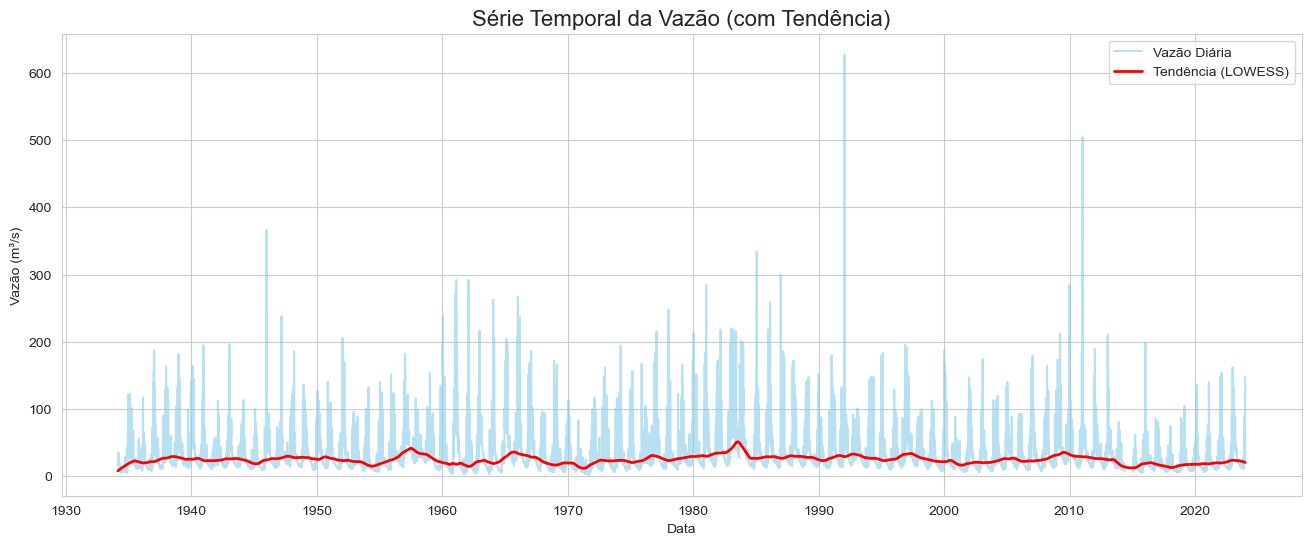

C:\Users\Rafae\AppData\Local\Temp\ipykernel_8336\3249195989.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Mes', y='Vazao', data=df, showfliers=False, palette='coolwarm', ax=ax)


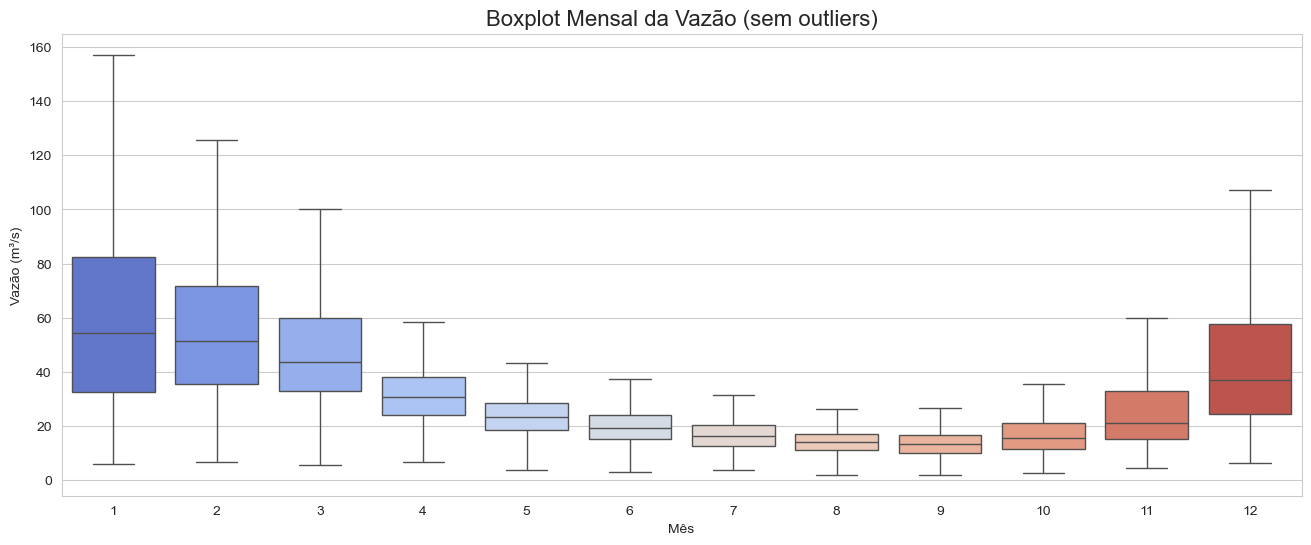

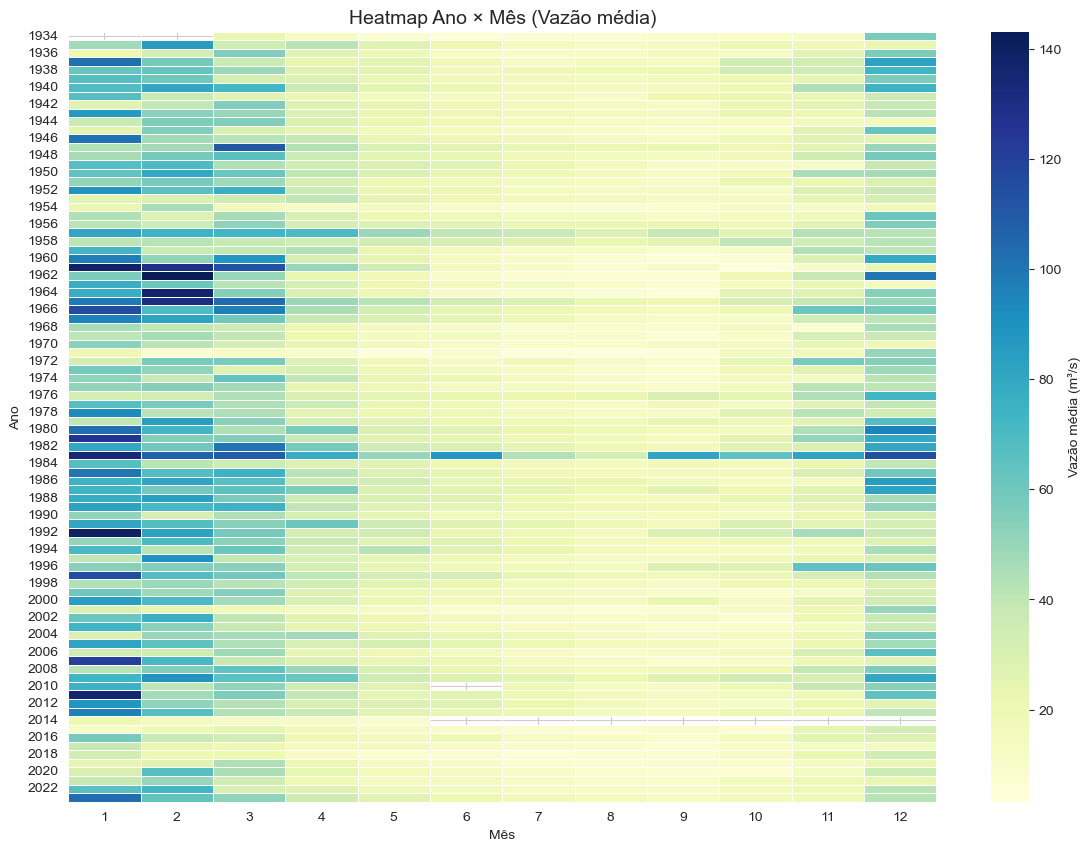

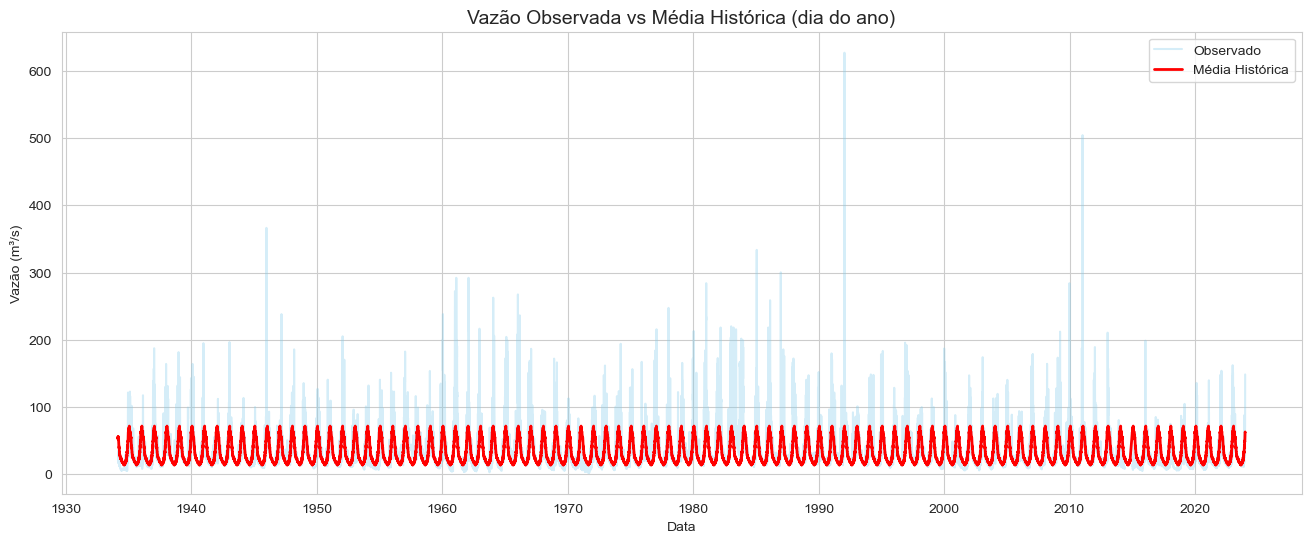

C:\Users\Rafae\AppData\Local\Temp\ipykernel_8336\3249195989.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Decada', y='Vazao', data=df2, showfliers=False, palette='viridis', ax=ax)


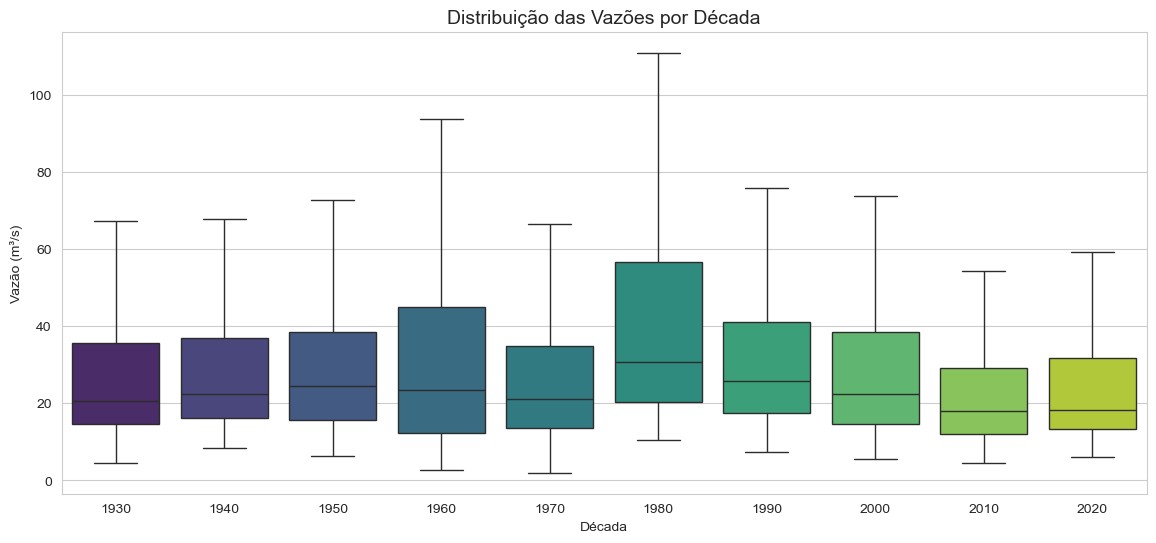

NameError: name 'calcular_indices' is not defined

In [7]:
import os
import matplotlib.pyplot as plt

# Criar pasta Graficos se não existir
os.makedirs("Graficos", exist_ok=True)

def salvar_e_mostrar(fig, nome_arquivo):
    """
    Salva a figura na pasta Graficos e mostra no notebook/IDE.
    """
    caminho = os.path.join("Graficos", nome_arquivo)
    fig.savefig(caminho, dpi=300, bbox_inches='tight')
    plt.show()  # mantém a exibição

# -----------------------------
# Pipeline de gráficos
# -----------------------------

# Exploratórios
fig = grafico_serie_temporal(df_long, return_fig=True)
salvar_e_mostrar(fig, "Serie_Temporal.png")

fig = grafico_boxplot_mensal(df_long, return_fig=True)
salvar_e_mostrar(fig, "Boxplot_Mensal.png")

fig = heatmap_ano_mes(df_long, return_fig=True)
salvar_e_mostrar(fig, "Heatmap_Ano_Mes.png")

fig = comparacao_media_historica(df_long, return_fig=True)
salvar_e_mostrar(fig, "Comparacao_Media_Historica.png")

fig = grafico_por_decada(df_long, return_fig=True)
salvar_e_mostrar(fig, "Grafico_por_Decada.png")

# -----------------------------
# Índices e eventos
# -----------------------------
indices = calcular_indices(df_long)

fig_evt, df_evt = detectar_secas_cheias(df_long, indices, return_fig=True)
salvar_e_mostrar(fig_evt, "Secas_Cheias.png")

# -----------------------------
# Previsão
# -----------------------------
modelo_prophet, forecast_prophet, out_prev = previsao_prophet(df_long, ano_fim=ano_fim_previsao)

fig_prev = grafico_previsao(modelo_prophet, forecast_prophet, df_long, return_fig=True)
salvar_e_mostrar(fig_prev, "Previsao_Prophet.png")


### -------------------------
### 9) Exportar agregados mensais e anuais (Excel-friendly)
### -------------------------

In [8]:
import os

# -----------------------------
# Criar pasta "Analises" se não existir
# -----------------------------
os.makedirs("Analises", exist_ok=True)

# -----------------------------
# CSV Mensal
# -----------------------------
df_mes = df_long.groupby(df_long['DataCompleta'].dt.to_period('M'))['Vazao'].agg(['mean','max','min','sum']).reset_index()
df_mes['DataMes'] = df_mes['DataCompleta'].dt.to_timestamp()
df_mes.rename(columns={'mean':'Vazao_Media','max':'Vazao_Max','min':'Vazao_Min','sum':'Vazao_Total'}, inplace=True)

df_mes[['DataMes','Vazao_Media','Vazao_Max','Vazao_Min','Vazao_Total']].to_csv(
    "Analises/Vazao_Mensal_Agregada.csv",
    index=False,
    sep=';',          # separador reconhecido pelo Excel BR
    decimal=',',      # decimal brasileiro
    encoding='utf-8'
)

# -----------------------------
# CSV Anual
# -----------------------------
df_ano = df_long.groupby(df_long['DataCompleta'].dt.year)['Vazao'].agg(['mean','max','min','sum']).reset_index()
df_ano.rename(columns={'year':'Ano','mean':'Vazao_Media','max':'Vazao_Max','min':'Vazao_Min','sum':'Vazao_Total'}, inplace=True)

df_ano.to_csv(
    "Analises/Vazao_Anual_Agregada.csv",
    index=False,
    sep=';',          # separador reconhecido pelo Excel BR
    decimal=',',      # decimal brasileiro
    encoding='utf-8'
)

# -----------------------------
# CSV Diário
# -----------------------------
df_long[['DataCompleta','Vazao']].to_csv(
    "Analises/Vazao_Diaria_ANA_Limpa.csv",
    index=False,
    sep=';',          
    decimal=',',      
    encoding='utf-8'
)
print("CSV diário salvo: Analises/Vazao_Diaria_ANA_Limpa.csv")

# -----------------------------
# Previsão Prophet até 2030
# -----------------------------
modelo, forecast, out_prev = previsao_prophet(df_long, ano_fim=2030)

df_prev = forecast[['ds','yhat_orig','yhat_lower_orig','yhat_upper_orig']].rename(columns={
    'ds':'Data',
    'yhat_orig':'Vazao_Prevista',
    'yhat_lower_orig':'Vazao_Prevista_Lower',
    'yhat_upper_orig':'Vazao_Prevista_Upper'
})

df_prev.to_csv(
    "Analises/Vazao_Prevista_Prophet_2030.csv",
    index=False,
    sep=';',        
    decimal=',',    
    encoding='utf-8'
)
print("CSV de previsão salvo: Analises/Vazao_Prevista_Prophet_2030.csv")


CSV diário salvo: Analises/Vazao_Diaria_ANA_Limpa.csv


20:21:25 - cmdstanpy - INFO - Chain [1] start processing
20:21:55 - cmdstanpy - INFO - Chain [1] done processing


Previsão salva: Vazao_Prevista_Prophet_2030.csv
CSV de previsão salvo: Analises/Vazao_Prevista_Prophet_2030.csv
